# Group constant generation with openMC

You receive this notebook already with evaluated cells, so you can just read it. However feel free to modify it for your own investigations! You do not need to submit this notebook. 

**NOTE** that you will need to use an environment where openMC is available if you intend to modify and run this notebook.

We will look at how to use openMC for group constant generation. For this first we setup a simple model: a slab which is infinite in y and z dimensions. The materials are set up so, that the core is close to criticality. The material is a homogeneous mixture of enriched uranium and water. (note the mixture and the size of the core is not the same here as in the previous lab).

The most important things here are the tallies at the end of the code block.

- we have defined a flux tally, with 1200 energy groups. We will use this to estimate the group constant the same way how we did during the datalab
- we have defined group constant tallies (eg. `fiss_1 = mgxs.FissionXS(domain=fuel,groups=G1,by_nuclide=True)
`). As you see these need to be added to the `tallies`
- for both the flux tally and for the group constants we selected the same lower and upper bound.

In [1]:
import openmc
import  numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs

fuelm = openmc.Material(1,"uo2")
fuelm.set_density('g/cm3', 10.0)
fuelm.add_nuclide('U235', 0.00153)
fuelm.add_nuclide('U238', 0.13847)
fuelm.add_nuclide('O16', 0.29)
fuelm.add_nuclide('H1', 0.57)
fuelm.add_s_alpha_beta('c_H_in_H2O')

mats = openmc.Materials([fuelm])
mats.export_to_xml()

rc=25.0
rf=27.0 #reflector not used now
core_1 = openmc.XPlane(x0=-rc)
core_2 = openmc.XPlane(x0=rc)

reflector_1 = openmc.XPlane(x0=-rf,boundary_type='vacuum')
reflector_2 = openmc.XPlane(x0=rf,boundary_type='vacuum')

fuel_region = +core_1 & -core_2
reflector1_region = +reflector_1 & -core_1
reflector2_region = +core_2 & -reflector_2

fuel = openmc.Cell(1, 'fuel')
fuel.fill = fuelm
fuel.region = fuel_region

reflector1 = openmc.Cell(2, 'reflector1')
reflector1.region = reflector1_region

reflector2 = openmc.Cell(3, 'reflector2')
reflector2.region = reflector2_region

root = openmc.Universe(cells=(fuel, reflector1, reflector2))

geom = openmc.Geometry()
geom.root_universe = root
geom.export_to_xml()

point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 150
settings.inactive = 20
settings.particles = 5000
settings.export_to_xml()

# Tally #1: energy spectrum in fuel

cell_filter = openmc.CellFilter(fuel)
energybins=np.logspace(-2,7,1201)
energy_filter = openmc.EnergyFilter(energybins)

t = openmc.Tally(1)
t.filters = [cell_filter,energy_filter]
t.scores = ['flux']#,'total', 'scatter']

####################################
#1G cross sections
G1 = openmc.mgxs.EnergyGroups()
G1.group_edges = np.array([1e-2,1e7])

tr_1  = mgxs.TransportXS(domain=fuel,energy_groups=G1)
tot_1 = mgxs.TotalXS    (domain=fuel,energy_groups=G1)
fiss_1 = mgxs.FissionXS(domain=fuel,energy_groups=G1,by_nuclide=True)

#all the tallies
tallies = openmc.Tallies([t])
tallies += tr_1.tallies.values()
tallies += tot_1.tallies.values()
tallies += fiss_1.tallies.values()
tallies.export_to_xml()
###################################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)


In [2]:
import os
os.system('rm summary.h5')
os.system('rm statepoint.150.h5')
openmc.run()

rm: cannot remove 'summary.h5': No such file or directory
rm: cannot remove 'statepoint.150.h5': No such file or directory


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now we will read the group constants from the statepoint file.

In [3]:
sp = openmc.StatePoint('statepoint.150.h5')
fiss_1p = mgxs.FissionXS(domain=fuel,energy_groups=G1,by_nuclide=True)
fiss_1p.load_from_statepoint(sp)
fiss_1p.print_xs()

Multi-Group XS
	Reaction Type  =	fission
	Domain Type    =	cell
	Domain ID      =	1
	Nuclide        =	U235
	Cross Sections [cm^-1]:
            Group 1 [0.01       - 10000000.0eV]:	2.12e-02 +/- 1.89e-01%

	Nuclide        =	U238
	Cross Sections [cm^-1]:
            Group 1 [0.01       - 10000000.0eV]:	2.02e-03 +/- 2.18e-01%

	Nuclide        =	O16
	Cross Sections [cm^-1]:
            Group 1 [0.01       - 10000000.0eV]:	0.00e+00 +/- 0.00e+00%

	Nuclide        =	H1
	Cross Sections [cm^-1]:
            Group 1 [0.01       - 10000000.0eV]:	0.00e+00 +/- 0.00e+00%





/usr/local/lib/python3.9/dist-packages/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]


# Comparison with our group constant generation

Now we will repeat the same what we did during the datalab. We will use the spectrum to weight the cross section, and compare it with the values calculated by openMC.

One can observe that the values agree rather well. During the datalab we have calculated slightly different values, but there we used data from JEFF 3.2, wheras here we use ENDF VIII.0 data.

In [4]:
import urllib.request

#website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'
website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=endfb8.0,92,235,9228,3,18'
with urllib.request.urlopen(website) as response:
    content235 = response.readlines()
    
def getXS(content):
    """Function to extract data from the html content provided by KAERI.
    the content has a shape as follows like:    
    Energy(eV) XS(b)<br>
    1.00000E-05 3.07139<br>"""
    energy=[]
    xs=[]
    flag=False
    i=0
    for line in content:
        x=line.strip().split()
        if  x[0]==b'Energy(eV)':
            flag=True
            continue
        if x[0]==b'</span>':
            flag=False
        if flag:
            energy.append(float(x[0]))
            xs.append(float(x[1][:-4]))
    return np.array(energy), np.array(xs)

energy,xs=getXS(content235)

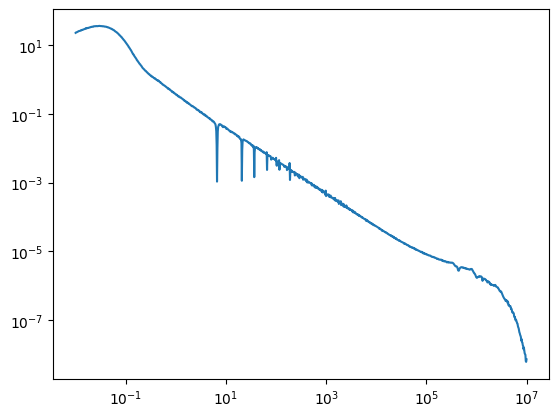

own estimate: 89.65 barn
openMC: 88.83 barn


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

tallydf=sp.tallies[1].get_pandas_dataframe()
enlow=tallydf['energy low [eV]']
enhigh=tallydf['energy high [eV]']
flux=tallydf['mean']

energyC=(enlow+enhigh)/2
fluxpE=flux/(enhigh-enlow)

plt.figure()
plt.loglog(energyC,fluxpE)
plt.show()

        
xs5interp=np.interp(energyC,energy,xs)

xs51g=np.trapz(xs5interp*fluxpE,energyC)/np.trapz(fluxpE,energyC)
print('own estimate: {:.2f} barn'.format(xs51g))
#since openMC provides macroscopic cross sections, we will need to divide with the number density of U235
print('openMC: {:.2f} barn'.format(fiss_1p.get_xs()[0,0]/fuelm.get_nuclide_atom_densities()['U235']))
